## Akhil Karri
# Self Driving Car using CNN
#### CS455 Machine Vision
#### Fall 2024

In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
# from tensorflow.python.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import cv2 as cv
import random
import os


In [ ]:
def getName(filepath):
     return filepath.split('\\')[-1]

def importDataInfo(path):
    cols = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed' ]
    data = pd.read_csv(os.path.join(path, 'driving_log.csv'), names=cols)
    print(data.head())

    data['Center'] = data['Center'].apply(getName)
    print('Total images in the data : ', data.shape[0])
    return data

In [21]:
def loadData(path,data):
    imagesPath = []
    steering= []
    for i in range(len(data)):
        indexedData = data.iloc[i]
        # print(indexedData)
        imagesPath.append(os.path.join(path, 'IMG' , indexedData[0]))
        steering.append(float(indexedData[3]))
    imagesPath = np.asarray(imagesPath)
    steering = np.asarray(steering)
    return imagesPath, steering

In [22]:
def dataBalancer(data, display = False):
    nBins = 31
    samplesPerBin = 1200
    hist, bins = np.histogram(data['Steering'], bins=nBins)
    center = (bins[:-1] + bins[1:]) * 0.5
    if display:
        plt.hist(data['Steering'], bins=nBins)
        plt.bar(center, hist, width = 0.05)
        plt.plot((-1, 1), (samplesPerBin, samplesPerBin))
        plt.show()
    removedIndexList = []
    for j in range(nBins):
        binDataList = []
        for i in range(len(data['Steering'])):
            if bins[j] <= data['Steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removedIndexList.extend(binDataList)
    print('removedIndexList', len(removedIndexList))
    data.drop(data.index[removedIndexList], inplace=True)
    print('Remainig images: ', len(data))
    if display:
        hist, _  = np.histogram(data['Steering'], bins=nBins)
        plt.hist(data['Steering'], bins=nBins)
        plt.bar(center, hist, width = 0.05)
        plt.show()
    return data

In [ ]:
def imageAugmentation(imgpath, steering):
    img = cv.imread(imgpath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # Panning the image randomly by 10%
    if np.random.rand() > 0.6:
        tx = int(img.shape[1] * np.random.uniform(-0.1, 0.1))
        ty = int(img.shape[0] * np.random.uniform(-0.1, 0.1))
        translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
        img = cv.warpAffine(img, translation_matrix, (img.shape[1], img.shape[0]))

    # Zoom in randomly by up to 20%
    if np.random.rand() > 0.6:
        zoom_factor = np.random.uniform(1.0, 1.2)
        height, width = img.shape[:2]
        center_x, center_y = width // 2, height // 2
        new_width, new_height = int(width / zoom_factor), int(height / zoom_factor)

        # Crop and resize to simulate zoom
        cropped_img = img[
            center_y - new_height // 2 : center_y + new_height // 2,
            center_x - new_width // 2 : center_x + new_width // 2
        ]
        img = cv.resize(cropped_img, (width, height), interpolation=cv.INTER_LINEAR)

    # Make the image darker or brighter
    if np.random.rand() > 0.6:
        brightness_factor = np.random.uniform(0.8, 1.2)
        img = cv.convertScaleAbs(img, alpha=brightness_factor, beta=0)

    # Flip the image and adjust steering
    if np.random.rand() > 0.6:
        img = cv.flip(img, 1)
        steering = -steering
    return img, steering

In [24]:
def preProcessing(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2YUV)
    img = img[60:135,:,:]
    img = cv.GaussianBlur(img, (3, 3), 0)
    img = cv.resize(img, (200, 66))
    img = img/255
    return img

# imgPre = preProcessing(cv.imread('data/IMG/center_2024_12_03_17_43_00_256.jpg'))
# plt.imshow(imgPre)
# plt.show()

In [25]:
def batchGen(imagesPath, steeringList, batchSize, trainFlag):
    while True:
         imgBatch = []
         steeringBatch = []

         for i in range(batchSize):
             index = random.randint(0, len(imagesPath) -  1)
             if trainFlag:
                img, steering = imageAugmentation(imagesPath[index], steeringList[i])
             else:
                 img = mpimg.imread(imagesPath[index])
                 steering = steeringList[index]
             img = preProcessing(img)
             imgBatch.append(img)
             steeringBatch.append(steering)
         yield(np.asarray(imgBatch), np.asarray(steeringBatch))

In [ ]:
def createModel():
  model = Sequential()

  # Convolutional layers with ELU activation
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (3, 3), activation='elu'))
  model.add(Conv2D(64, (3, 3), activation='elu'))

  # Fully connected layers
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dense(50, activation='elu'))
  model.add(Dense(10, activation='elu'))
  model.add(Dense(1))  

  model.compile(optimizer='adam', loss='mse', metrics=['mae'])

  return model

In [27]:
model = createModel()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
path = '/content/drive/MyDrive/data'
data = importDataInfo(path)

                                              Center  \
0  C:\Users\akhilkarri\Downloads\term1-simulator-...   
1  C:\Users\akhilkarri\Downloads\term1-simulator-...   
2  C:\Users\akhilkarri\Downloads\term1-simulator-...   
3  C:\Users\akhilkarri\Downloads\term1-simulator-...   
4  C:\Users\akhilkarri\Downloads\term1-simulator-...   

                                                Left  \
0  C:\Users\akhilkarri\Downloads\term1-simulator-...   
1  C:\Users\akhilkarri\Downloads\term1-simulator-...   
2  C:\Users\akhilkarri\Downloads\term1-simulator-...   
3  C:\Users\akhilkarri\Downloads\term1-simulator-...   
4  C:\Users\akhilkarri\Downloads\term1-simulator-...   

                                               Right  Steering  Throttle  \
0  C:\Users\akhilkarri\Downloads\term1-simulator-...       0.0       0.0   
1  C:\Users\akhilkarri\Downloads\term1-simulator-...       0.0       0.0   
2  C:\Users\akhilkarri\Downloads\term1-simulator-...       0.0       0.0   
3  C:\Users\akhilkarri

In [30]:
data = dataBalancer(data)

imagesPath, steering  = loadData(path, data)

x_train, x_val, y_train, y_val = train_test_split(imagesPath, steering, test_size=0.2, random_state=42)
print('training and validation set shape: ', x_train.shape, x_val.shape)

removedIndexList 3325
Remainig images:  6226


<ipython-input-21-dca90fd4008b>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  imagesPath.append(os.path.join(path, 'IMG' , indexedData[0]))
<ipython-input-21-dca90fd4008b>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexedData[3]))


training and validation set shape:  (4980,) (1246,)


In [ ]:
!pip install tensorflow==2.12.0

In [ ]:
history = model.fit( batchGen(x_train, y_train, batchSize=100, trainFlag=True), steps_per_epoch=300,epochs=10, validation_data=batchGen(x_val, y_val, batchSize=100, trainFlag=False), validation_steps=200)

Epoch 1/10
300/300 [==============================] - 2178s 7s/step - loss: 0.2207 - mae: 0.3058 - val_loss: 0.1505 - val_mae: 0.2576
Epoch 2/10
300/300 [==============================] - 224s 751ms/step - loss: 0.1559 - mae: 0.2770 - val_loss: 0.1496 - val_mae: 0.2555
Epoch 3/10
300/300 [==============================] - 222s 744ms/step - loss: 0.1557 - mae: 0.2768 - val_loss: 0.1514 - val_mae: 0.2603
Epoch 4/10
300/300 [==============================] - 222s 742ms/step - loss: 0.1570 - mae: 0.2794 - val_loss: 0.1484 - val_mae: 0.2556
Epoch 5/10
300/300 [==============================] - 222s 744ms/step - loss: 0.1555 - mae: 0.2761 - val_loss: 0.1497 - val_mae: 0.2605
Epoch 6/10
300/300 [==============================] - 223s 744ms/step - loss: 0.1554 - mae: 0.2759 - val_loss: 0.1525 - val_mae: 0.2601
Epoch 7/10
300/300 [==============================] - 223s 744ms/step - loss: 0.1553 - mae: 0.2756 - val_loss: 0.1516 - val_mae: 0.2599
Epoch 8/10
300/300 [==============================

In [ ]:
model.save('model.h5')
print('model saved')

model saved


In [ ]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

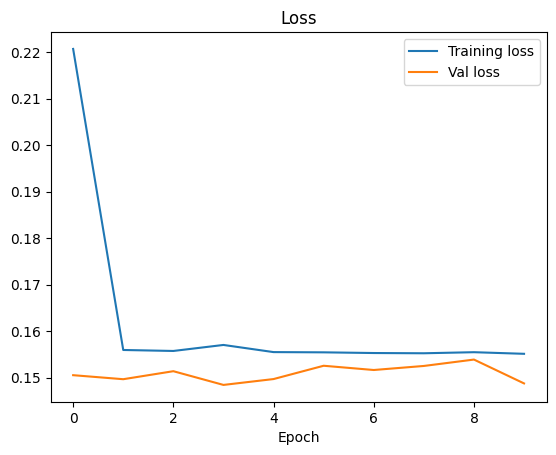

In [ ]:
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'])
plt.legend(['Training loss', 'Val loss'])
plt.title('Loss')
# plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.show()

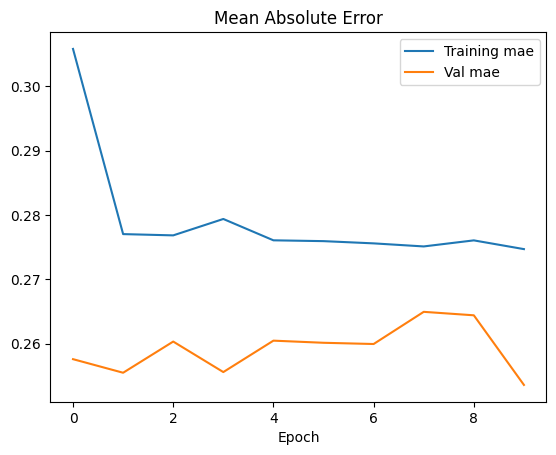

In [35]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Training mae', 'Val mae'])
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.show()